In [35]:
import math
value_error = TypeError("Value type can only hold float scalars")

def parse_value(x):
        if isinstance(x, (int, float)):
            x = Value(float(x))
        elif not isinstance(x, Value):
            raise value_error
        return x
    
class Value:
    def __init__(self, data, _children=()):
        if isinstance(data, (int, float)):
            data = float(data)
        else:
            raise value_error
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
    
    def __add__(self, other):
        other = parse_value(other)
        res = Value(self.data + other.data, (self, other))
        def _backward():
            self.grad += res.grad
            other.grad += res.grad
        res._backward = _backward
        return res
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = parse_value(other)
        res = Value(self.data * other.data, (self, other))
        def _backward():
            self.grad += other.data * res.grad
            other.grad += self.data * res.grad
        res._backward = _backward
        return res
    def __rmul__(self, other):
        return self * other
    def __neg__(self):
        return self * -1
        
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return -self + other

    def __truediv__(self, other):
        other = parse_value(other)
        if other.data == 0:
            raise ZeroDivisionError()
        return self * other ** -1
    def __rtruediv__(self, other):
        other = parse_value(other)
        return other / self

    def exp(self):
        res = Value(math.e ** self.data, (self,))
        def _backward():
            self.grad += res.data * res.grad
        res._backward = _backward
        return res

    def sigmoid(self):
        pass
        
    def tanh(self):
        pass

    def relu(self):
        res = Value(max(0, self.data), (self,))
        def _backward():
            if self.data > 0:
                self.grad += res.grad
        res._backward = _backward
        return res

    def __pow__(self, other):
        if not isinstance(other, (int, float)):
            raise NotImplementedError("Value type can only be raised to int/float powers")
        res = Value(self.data ** other, (self,))
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * res.grad
        res._backward = _backward
        return res
    def __rpow__(self, other):
        raise NotImplementedError("Value type can only be raised to int/float powers")

    def zero_grad(self):
        self.grad = 0.0
        
    def backward(self):
        _ordered = list()
        _visited = set()
        def add_list(curr):
            if curr not in _visited:
                _visited.add(curr)
                for p in curr._prev:
                    add_list(p)
                _ordered.append(curr)
        add_list(self)
        self.grad = 1.0
        for value in reversed(_ordered):
            value._backward()

    def __float__(self):
        return self.data
        
    def __repr__(self):
        return f"Value({self.data}, grad={self.grad})"

In [36]:
# minimize (x-6)^4
x = Value(20)
lr = 0.001
epochs = 10000
for i in range(epochs + 1):
    f = (x - 6) ** 4
    f = f.relu()
    f.backward()
    x.data -= lr * x.grad
    if i % (epochs / 10) == 0:        
        print(f"[{i}]\tx: {x.data}: f(x): {f.data}")
    x.zero_grad()

[0]	x: 9.024: f(x): 38416.0
[1000]	x: 6.3505989247898: f(x): 0.015139010989210725
[2000]	x: 6.248917153024456: f(x): 0.0038428205805274666
[3000]	x: 6.203523253643355: f(x): 0.0017168964178104946
[4000]	x: 6.1763812606098085: f(x): 0.0009683358550389645
[5000]	x: 6.157828121108429: f(x): 0.0006207413540471358
[6000]	x: 6.144118450433309: f(x): 0.0004315416237252089
[7000]	x: 6.133455585691857: f(x): 0.0003173005345447142
[8000]	x: 6.1248559227151365: f(x): 0.00024307759708722782
[9000]	x: 6.117729787268654: f(x): 0.00019215060742499752
[10000]	x: 6.111699338768181: f(x): 0.00015570018082493382


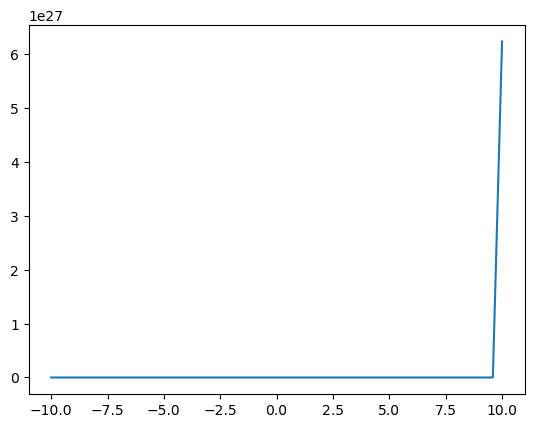

In [37]:
import numpy as np
import matplotlib.pyplot as plt
def get_val(x):
    x = Value(x)
    f = (x - 6) ** 3
    f = f.relu()
    f = f.exp()
    return f

xs = np.array(np.linspace(-10, 10, 50), dtype=float)
ys = np.array([get_val(x) for x in xs])
plt.plot(xs, ys)